# MSEE UQ short course: Day 2 
## Surrogates -PCE
https://uqpyproject.readthedocs.io/en/latest/surrogates_doc.html#polynomial-chaos-expansion-pce

## Surrogates -Kriging
https://uqpyproject.readthedocs.io/en/latest/surrogates_doc.html#gaussian-process-regression-kriging

# Exercise - PCE

In this exercise you are asked to build a PCE surrogate for (i) the Boucwen Python model and, (ii) for the third-party contact sphere model. Realizations of the input random variables are obtained via Monte Carlo sampling - see $\bf{SampleMethods}$ module in UQpy. 


1. Build a PCE surrogate for the 1-D Boucwen model. In this case, randomness is assumed in the systems' parameters $r_{0}$ (assuming $k=1.0$ cm, $\delta=0.9$ cm and no damping, $c=0$). Consider two cases: In the first case, parameter $r_{0}$ is assumed to be uniformly distributed $\sim \mathcal{U}(0.5, 3.5)$ cN/cm. In the second case, $r_{0}$ is normally distributed $\sim \mathcal{N}(2.5, 0.016)$. Build a PCE surrogate to approximate the response function of the the maximum value of the reaction force. 

    - Generate 20 training data (i.e., input-output pairs) using MCS and visualize the response function. 
    - Construct a validation set with 20 data.
    - Set the maximum degree of the PCE to $p$=1. 
    - Compute the PCE coefficients using least square regression.
    - Compute the validation error.
    - Compare the results for  PCE order $p=2$.


2. Build a PCE surrogate for the 2-D Boucwen model. In this case, randomness is assumed in the systems' parameters [$k, \delta$] (assuming $r_{0}=2.5$ cm and no damping, $c=0$). Consider two cases: In the first case, both parameters $k$ and $\delta$ are assumed to be uniformly distributed between 0.5 cN/cm and 2.5 cN/cm and 0.2 cm and 2.8 cm. In the second case, both parameters are assumed to be normally distributed, with $k\sim \mathcal{N}(2.5, 0.016)$ and $\delta \sim \mathcal{N}(0.9, 0.01)$. Build a PCE surrogate to approximate the response surface of the the maximum value of the reaction force. 

    - Generate 100 training data (i.e., input-output pairs in a grid of 10x10) and visualize the response surface. 
    - Construct a validation set with 20 data.
    - Set the maximum degree of the PCE to p=2.
    - Compute the PCE coefficients using least square, Lasso and Ridge regression.
    - Predict the maximum reaction force at a set of 1000 new points and compute the validati
    - Estimate the first two moments (mean and variance) of the PCE surrogate  for: least square, Lasso and Ridge regression. 
    - Compare the results for increasing number of PCE order $p$.  
    
    
3. Build a PCE surrogate for the 2-D contact sphere model. In the indentation test model randomness is assumed in the parameters [$k, f0$]. Parameter $k$ is assumed to follow a Lognormal distribution with the parameters of the underlying Gaussian distribution being: $\mu$ = 1e5 and standard deviation $\sigma=2e4$.The parameters of the lognormal distribution in this case are $s=0.19804$ and $scale=98058.0675$ ($loc$=0.0). Parameter $f0$ is assumed to follow a uniform distribution in the range [1e-2, 1e-1]. Build a PCE surrogate to approximate the response surface of the maximum displacement at the identation point. 

    - Generate 100 training data (i.e., input-output pairs in a grid of 10x10) and visualize the response surface. 
    - Construct a validation set with 20 data.
    - Set the maximum degree of the PCE to p=5.
    - Compute the PCE coefficients using least square, Lasso and Ridge regression.
    - Predict the maximum reaction force at a set of 10,000 new points.
    - Estimate the first two moments (mean and variance) of the PCE surrogate  for: least square, Lasso and Ridge regression. 
    - Compare the results for PCE order $p=1$.  

UQpy: Running Monte Carlo Sampling.
UQpy: Monte Carlo Sampling Complete.


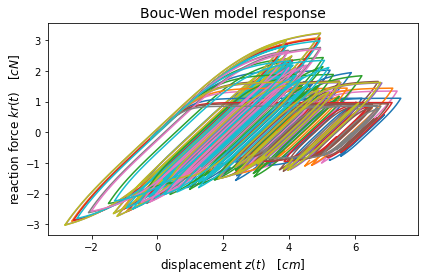

UQpy: Running Monte Carlo Sampling.
UQpy: Monte Carlo Sampling Complete.
UQpy: Running Monte Carlo Sampling.
UQpy: Monte Carlo Sampling Complete.
Error from least squares regression is:  3e-06


In [1]:
#Solution 1.1 - case 1
from UQpy.RunModel import RunModel
from UQpy.Distributions import Uniform
from UQpy.SampleMethods import MCS
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Surrogates import *

boucwen = RunModel(model_script='model_1D.py', model_object_name='boucwen', var_names=['r0'])

distribution_k_case_1 = Uniform(loc=0.5, scale=3.0) 
monte_carlo_sampling_1 = MCS(dist_object=[distribution_k_case_1], nsamples=20,  verbose=True)
samples = monte_carlo_sampling_1.samples

boucwen.run(samples=samples)
qoi = boucwen.qoi_list

maximum_forces=list()
for result in qoi:
    maximum_forces.append(max(result[1]))

plt.figure()
for result in qoi:
    plt.plot(result[0], result[1])
plt.xlabel('displacement $z(t) \quad [cm]$', fontsize=12) 
plt.ylabel(r'reaction force $k r(t) \quad [cN]$', fontsize=12); 
plt.title('Bouc-Wen model response', fontsize=14)
plt.tight_layout()
plt.show()

    
validation_sampling=MCS(dist_object=[distribution_k_case_1], nsamples=20,  verbose=True)
boucwen.run(samples=validation_sampling.samples)
maximum_forces_validation=list()
for result in boucwen.qoi_list[-20:]:
    maximum_forces_validation.append(max(result[1]))

max_degree = 1
polys = Polynomials(dist_object=distribution_k_case_1, degree=max_degree) 
lstsq = PolyChaosLstsq(poly_object=polys)
pce = PCE(method=lstsq) 

pce.fit(samples,np.array(maximum_forces))

prediction_sampling=MCS(dist_object=[distribution_k_case_1], nsamples=100,  verbose=True)
prediction_results=pce.predict(prediction_sampling.samples)

error = ErrorEstimation(surr_object=pce)
print('Error from least squares regression is: ', error.validation(validation_sampling.samples, np.array(maximum_forces_validation)))

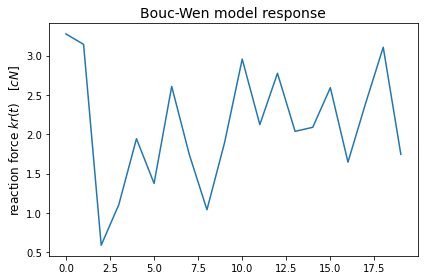

In [3]:
plt.figure()
plt.plot(maximum_forces_validation)
plt.ylabel(r'reaction force $k r(t) \quad [cN]$', fontsize=12); 
plt.title('Bouc-Wen model response', fontsize=14)
plt.tight_layout()
# plt.show()

In [ ]:
#Solution 1.2 - case 1
from UQpy.RunModel import RunModel
from UQpy.Distributions import *
from UQpy.SampleMethods import MCS
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Surrogates import *
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

boucwen = RunModel(model_script='model_2D.py', model_object_name='boucwen', var_names=['k', 'r0', 'delta'])

distribution_k_case_1 = Uniform(loc=0.5, scale=2) 
distribution_delta_case_1 = Uniform(loc=0.2, scale=2.6) 
joint = JointInd(marginals=[distribution_k_case_1,distribution_delta_case_1])
#distribution_k_case_2 = Normal(loc=2.5, scale=0.016) 
#distribution_delta_case_2 = Normal(loc=0.9, scale=0.01) 
monte_carlo_sampling_1 = MCS(dist_object=joint, nsamples=100,  verbose=True)
samples = monte_carlo_sampling_1.samples

boucwen.run(samples=samples)
qoi = boucwen.qoi_list

maximum_forces=list()
for result in qoi:
    maximum_forces.append(max(result[1]))


fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(samples[:,0], samples[:,1], maximum_forces, s=20, c='r')

ax.set_title('Training data')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,140)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$delta$', fontsize=15)
ax.set_zlabel(r'reaction force $k r(t) \quad [cN]$', fontsize=15)
plt.show()

validation_sampling=MCS(dist_object=joint, nsamples=20,  verbose=True)
boucwen.run(samples=validation_sampling.samples)
maximum_forces_validation=list()
for result in boucwen.qoi_list[-20:]:
    maximum_forces_validation.append(max(result[1]))

max_degree = 3
polys = Polynomials(dist_object=joint, degree=max_degree) 
lstsq = PolyChaosLstsq(poly_object=polys)
pce = PCE(method=lstsq) 

# lasso = PolyChaosLasso(poly_object=polys, learning_rate=0.01, iterations=1000, penalty=0.1)
# pce2 = PCE(method=lasso) 

# ridge = PolyChaosRidge(poly_object=polys, learning_rate=0.01, iterations=1000, penalty=0.1)
# pce3 = PCE(method=ridge) 

pce.fit(samples,np.array(maximum_forces))

prediction_sampling=MCS(dist_object=[distribution_k_case_1,distribution_delta_case_1], nsamples=10000,  verbose=True)
prediction_results=pce.predict(prediction_sampling.samples)


print('Moments from least squares regression :', MomentEstimation(surr_object=pce).get())
# print('Moments from LASSO regression :', MomentEstimation(surr_object=pce2).get())
# print('Moments from Ridge regression :', MomentEstimation(surr_object=pce3).get())

In [ ]:
#Solution 1.3
from UQpy.RunModel import RunModel
from UQpy.Distributions import *
from UQpy.SampleMethods import MCS
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Surrogates import *
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

model_serial_third_party=RunModel(model_script='PythonAsThirdParty_model.py',
   input_template='elastic_contact_sphere.py', var_names=['k', 'f0'],
   output_script='process_3rd_party_output.py', model_object_name='read_output', delete_files=True)


distribution_k_case_1 = Lognormal(loc=1e5, scale=2e4) 
distribution_f0_case_1 = Uniform(loc=1e-2, scale=9e-2) 
joint = JointInd(marginals=[distribution_k_case_1,distribution_f0_case_1])
monte_carlo_sampling_1 = MCS(dist_object=joint, nsamples=100,  verbose=True)
samples = monte_carlo_sampling_1.samples

model_serial_third_party.run(samples=samples)
qoi = model_serial_third_party.qoi_list

maximum_forces=list()
for result in qoi:
    maximum_forces.append(max(result[1]))


fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(samples[:,0], samples[:,1], maximum_forces, s=20, c='r')

ax.set_title('Training data')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,140)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$delta$', fontsize=15)
ax.set_zlabel(r'reaction force $k r(t) \quad [cN]$', fontsize=15)
plt.show()

validation_sampling=MCS(dist_object=joint, nsamples=20,  verbose=True)
model_serial_third_party.run(samples=validation_sampling.samples)
maximum_forces_validation=list()
for result in model_serial_third_party.qoi_list[-20:]:
    maximum_forces_validation.append(max(result[1]))

max_degree = 5
polys = Polynomials(dist_object=joint, degree=max_degree) 
lstsq = PolyChaosLstsq(poly_object=polys)
pce = PCE(method=lstsq) 

# lasso = PolyChaosLasso(poly_object=polys, learning_rate=0.01, iterations=1000, penalty=0.1)
# pce2 = PCE(method=lasso) 

# ridge = PolyChaosRidge(poly_object=polys, learning_rate=0.01, iterations=1000, penalty=0.1)
# pce3 = PCE(method=ridge) 

pce.fit(samples,np.array(maximum_forces))

prediction_sampling=MCS(dist_object=[distribution_k_case_1,distribution_delta_case_1], nsamples=10000,  verbose=True)
prediction_results=pce.predict(prediction_sampling.samples)


print('Moments from least squares regression :', MomentEstimation(surr_object=pce).get())
# print('Moments from LASSO regression :', MomentEstimation(surr_object=pce2).get())
# print('Moments from Ridge regression :', MomentEstimation(surr_object=pce3).get())

# Exercise 2 - Kriging


In this example you are asked to build a Kriging surrogate for the Boucwen Python model and for the third-party contact sphere model. Samples of the input uncertainties must be obtained via Latin hypercube sampling - see $\bf{SampleMethods}$ module in UQpy. 

1. Build a Kriging surrogate for 1-D contact sphere model. In the indentation test model randomness is assumed in the parameter $k$ which is assumed to follow a Lognormal distribution, with the parameters of the underlying Gaussian distribution being: $\mu$ = 1e5 and standard deviation $\sigma=2e4$.The parameters of the lognormal distribution in this case are $s=0.19804$ and $scale=98058.0675$ ($loc$=0.0).  Build a Kriging surrogate to approximate the response function of the maximum displacement at the identation point. 

    - Generate 100 training data (i.e., input-output pairs) using Latin Hypercube sampling (LHS) and visualize the response function. 
    - Construct a validation set with 20 data.
    - Train a Universal Kriging using a Gaussian correlation model. 
    - Predict the maximum displacement at the identation point at a set of 1000 new points.
    - Compute the validation error.
    - Compare the results for different correlation models.
    
    
2. Build a Kriging surrogate for 2-D contact sphere model. In the indentation test model randomness is assumed in the parameters [$k, f0$]. Parameter $k$ is assumed to follow a Lognormal distribution with the parameters of the underlying Gaussian distribution being: $\mu$ = 1e5 and standard deviation $\sigma=2e4$.The parameters of the lognormal distribution in this case are $s=0.19804$ and $scale=98058.0675$ ($loc$=0.0). Parameter $f0$ is assumed to follow a uniform distribution in the range [1e-2, 1e-1]. Build a Kriging surrogate to approximate the response surface of the maximum displacement at the identation point. 

    - Generate 100 training data (i.e., input-output pairs in a 2D grid) using Latin Hypercube sampling (LHS) and visualize the response surface. 
    - Construct a validation set with 20 data.
    - Train an Ordinary Kriging using an exponential correlation model. 
    - Predict the maximum displacement at the identation point at a set of 500 new points.
    - Compute the validation error.
    - Compare the results with the PCE models. 
    
    
 3. Build a Kriging surrogate for 1-D Boucwen model. In this case, randomness is assumed in the systems' parameters $r_{0}$ (assuming $k=1.0$ cm, $\delta=0.9$ cm and no damping, $c=0$). Consider the case where  $r_{0}$ is assumed to be uniformly distributed $\sim \mathcal{U}(0.5, 3.5)$ cN/cm. Build a Kriging surrogate to approximate the response function of the the maximum value of the reaction force. 

    - Generate 20 training data (i.e., input-output pairs) using Latin Hypercube sampling (LHS) and visualize the response function. 
    - Construct a validation set with 20 data.
    - Train a Universal Kriging using a Gaussian correlation model. 
    - Predict the maximum reaction force at a set of 1000 new points.
    - Compute the validation error.
    - Compare the results with PCE.

In [ ]:
#Solution 2.2
from UQpy.RunModel import RunModel
from UQpy.Distributions import *
from UQpy.SampleMethods import MCS
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Surrogates import *
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

model_serial_third_party=RunModel(model_script='PythonAsThirdParty_model.py',
   input_template='elastic_contact_sphere.py', var_names=['k', 'f0'],
   output_script='process_3rd_party_output.py', model_object_name='read_output', delete_files=True)


distribution_k_case_1 = Lognormal(loc=1e5, scale=2e4) 
distribution_f0_case_1 = Uniform(loc=1e-2, scale=9e-2) 
joint = JointInd(marginals=[distribution_k_case_1,distribution_f0_case_1])
sampling_1 = LHS(dist_object=joint, nsamples=100,  verbose=True)
samples = sampling_1.samples

model_serial_third_party.run(samples=samples)
qoi = model_serial_third_party.qoi_list

maximum_indentation=list()
for result in qoi:
    maximum_forces.append(max(result[1]))


fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(samples[:,0], samples[:,1], maximum_indentation, s=20, c='r')

ax.set_title('Training data')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,140)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$f0$', fontsize=15)
ax.set_zlabel('Maximum identation', fontsize=15)
plt.show()

validation_sampling=LHS(dist_object=joint, nsamples=20,  verbose=True)
model_serial_third_party.run(samples=validation_sampling.samples)

maximum_identation_validation=list()
for result in model_serial_third_party.qoi_list[-20:]:
    maximum_identation_validation.append(max(result[1]))

K = Kriging(reg_model='Linear', corr_model='Gaussian', nopt=20, corr_model_params=[1])
K.fit(samples=samples, values=maximum_forces)

prediction_sampling=MCS(dist_object=[distribution_k_case_1,distribution_delta_case_1], nsamples=10000,  verbose=True)
prediction_results=pce.predict(prediction_sampling.samples)




In [ ]:
#Solution 2.3 - case 1
from UQpy.RunModel import RunModel
from UQpy.Distributions import Uniform
from UQpy.SampleMethods import LHS
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Surrogates import *

boucwen = RunModel(model_script='model_1D.py', model_object_name='boucwen', var_names=['r0'])

distribution_k_case_1 = Uniform(loc=0.5, scale=2) 
#distribution_k_case_2 = Normal(loc=2.5, scale=0.016) 
sampling_1 = LHS(dist_object=[distribution_k_case_1], nsamples=20,  verbose=True)
samples = sampling_1.samples

boucwen.run(samples=samples)
qoi = boucwen.qoi_list

maximum_forces=list()
for result in qoi:
    maximum_forces.append(max(result[1]))

plt.figure()
for result in qoi:
    plt.plot(result[0], result[1])
plt.xlabel('displacement $z(t) \quad [cm]$', fontsize=12) 
plt.ylabel(r'reaction force $k r(t) \quad [cN]$', fontsize=12); 
plt.title('Bouc-Wen model response', fontsize=14)
plt.tight_layout()
# plt.show()

validation_sampling=LHS(dist_object=[distribution_k_case_1], nsamples=20,  verbose=True)
boucwen.run(samples=validation_sampling.samples)
maximum_forces_validation=list()
for result in boucwen.qoi_list[-20:]:
    maximum_forces_validation.append(max(result[1]))

K = Kriging(reg_model='Linear', corr_model='Gaussian', nopt=20, corr_model_params=[1])
K.fit(samples=samples, values=maximum_forces)

prediction_sampling=LHS(dist_object=[distribution_k_case_1], nsamples=1000,  verbose=True)
prediction_results=K.predict(prediction_sampling.samples.reshape([1000, 1]), return_std=False)

# 